# 任务 1：加载数据集

In [1]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

小批量梯度下降：

In [2]:
import torch

batch_size = 4

# CIFAR10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

# 构建数据规范化变换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 构建 torchvision.datasets.CIFAR10 对象
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 构建 torch.utils.data.DataLoader 对象
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# 模仿训练数据集对象实例的建立方式，构建测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


在完成数据加载后，可以使用以下代码检查加载数据的正确性。

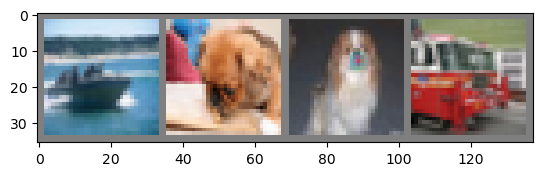

 ship   dog   dog truck


In [3]:
# 可视化部分训练数据
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机取一个批次的训练数据
dataiter = iter(trainloader)
images, labels = next(dataiter)
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 打印相关图像的标签
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 任务 2: 定义卷积神经网络

考虑使用一个由二维卷积层、池化层、二维卷积层后接三个全连接层组成的卷积神经网络完成图像分类任务。

        #  conv1: Conv2d(3, 6, kernel_size=5)
        #  pool:  MaxPool2d(kernel_size=2, stride=2)
        #  conv2: Conv2d(6, 32, kernel_size=5)  
        #  fc1: Linear(in_features=400, out_features=120)
        #  fc2: Linear(in_features=120, out_features=84)
        #  fc3: Linear(in_features=84, out_features=10)

在 PyTorch 中，每个神经网络模型都需要定义一个 `forward` 方法，该方法描述了当输入数据传入模型时，数据应如何经过各个层级处理并最终输出结果。下面结合我们的网络代码逐步解释 `forward(self, x)` 的过程：

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

实例化网络并打印结构

In [5]:
net = MyNet()
print("\nNetwork architecture:\n")
print(net)

for name, param in net.named_parameters():
    print(f"{name}: {param.data.shape}")


Network architecture:

MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1.weight: torch.Size([32, 3, 5, 5])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 5, 5])
conv2.bias: torch.Size([64])
fc1.weight: torch.Size([120, 1600])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])


# 任务 3: 定义损失函数和优化器

我们使用分类的交叉熵 (Classification Cross Entropy) 损失与带动量 (momentum) 的随机梯度下降 (Stochastic Gradient Descent, SGD) 方法进行模型优化。

配置训练参数：  
损失函数：交叉熵损失  
优化器：带动量的随机梯度下降（学习率0.001，动量0.9）

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 任务 4: 训练图像分类器

对前面定义的分类器进行训练

In [7]:
from tqdm.notebook import tqdm
import time

n_epochs = 2
n_batches = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net.to(device)

print("Starting training...")
start_time = time.time()

for epoch in range(n_epochs):
    # 当前 n_batches 个小批次训练数据上的平均损失
    running_loss = 0.0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for i, data in enumerate(pbar, 0):
        # 获取数据及标签，并转移到 GPU（若可用）
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 梯度清零，防止累加
        optimizer.zero_grad()
        # 前向传播
        outputs = net(inputs)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新模型参数
        optimizer.step()

        # 统计损失函数的滑动平均
        running_loss += loss.item()
        if (i+1) % n_batches == 0:
            pbar.set_postfix(batch=i+1, loss=running_loss/n_batches)
            running_loss = 0.0
        pbar.update() # 更新进度条

end_time = time.time()
print("Training completed. Total time: {:.2f}s".format(end_time - start_time))

Using device: cuda:0
Starting training...


Epoch 1/2:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/12500 [00:00<?, ?it/s]

Training completed. Total time: 49.13s


使用下述代码将模型存储到硬盘上

In [8]:
model_path = "./models/cifar_net.pth"
torch.save(net.state_dict(), model_path)
print("Model saved to", model_path)

Model saved to ./models/cifar_net.pth


# 任务 5: 在测试集上评估模型性能

In [9]:
net = MyNet() 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
net.to(device)  

net.load_state_dict(
    torch.load(model_path, 
             map_location=device,  # 确保权重映射到当前设备
             weights_only=True     # 消除安全警告
    )
)

correct = 0
total = 0

with torch.no_grad():# 禁用梯度计算以节省内存
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Overall accuracy on test set: %.1f%%" % (100 * correct / total))

Using device:  cuda:0
Overall accuracy on test set: 65.3%


# 任务 6: 统计各类别测试样本准确率

In [10]:
print("Calculating per-class accuracy...")
class_correct = [0.] * 10
class_total = [0.] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            class_correct[label] += (predicted[i] == labels[i]).item()

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Calculating per-class accuracy...
Accuracy of plane : 78 %
Accuracy of   car : 84 %
Accuracy of  bird : 33 %
Accuracy of   cat : 51 %
Accuracy of  deer : 44 %
Accuracy of   dog : 60 %
Accuracy of  frog : 83 %
Accuracy of horse : 68 %
Accuracy of  ship : 81 %
Accuracy of truck : 66 %
